# 畳み込み演算


### 畳み込み演算の特徴
+ 線形変換
+ 全結合に比べて疎結合
+ パラメータがすべて共通
+ パラメータ数が少ない
+ 移動不変性を獲得できる (画像全体に渡る同一カーネルの重みを使用)
+ 局所性のある特徴量を獲得できる (移動させたカーネルと画像のスカラ積)

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = "C:\\Users\\inoue\\Documents\\AI_Learning_Dataset\\"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
conv = nn.Conv2d(
    in_channels=3,
    out_channels=16,
    kernel_size=3
)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [7]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [9]:
# img.shape
# img = img.mean(dim=0)
# img.shape

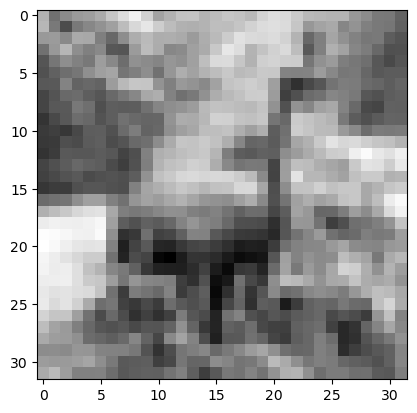

In [10]:
plt.imshow(img.mean(dim=0), cmap='gray')
plt.show()

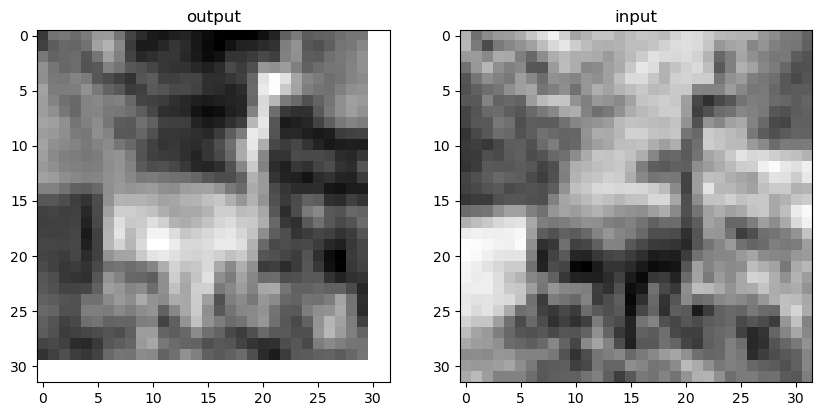

In [11]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(dim=0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

#### 畳み込み演算にPaddingを追加することで特徴量マップのサイズを同じにできる

In [12]:
# 微分カーネル
conv = nn.Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=3,
    padding=1 # パディング
)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()


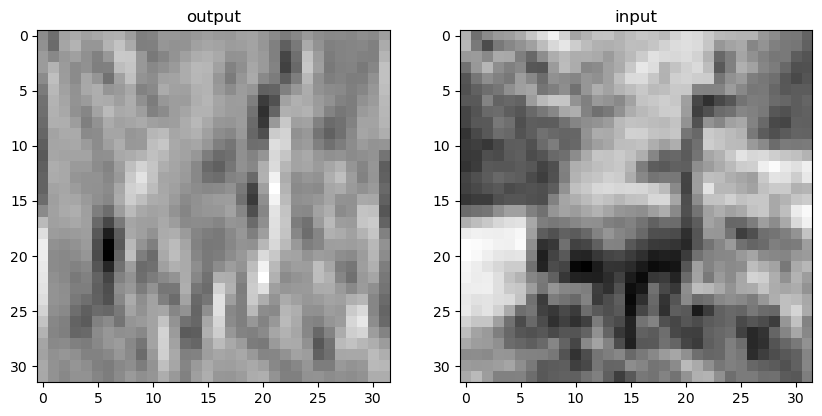

In [13]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

In [14]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

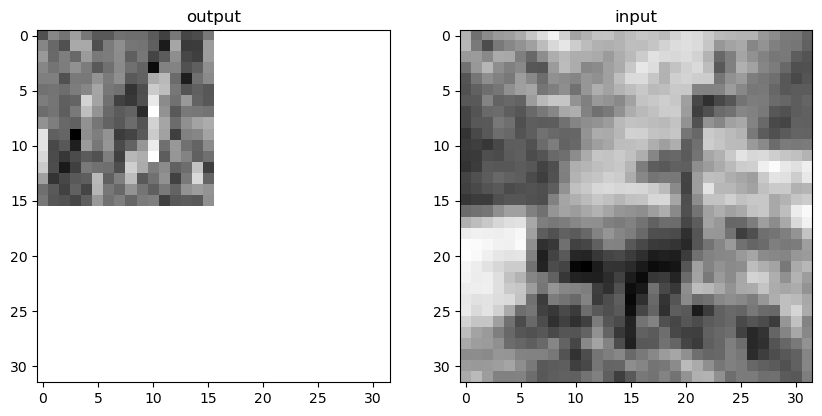

In [15]:
output = pool(conv(img.unsqueeze(0)))

plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

In [16]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

# nn.Moduleによるモデルの作成

Module APIは, 独自なモデルを作成できる

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # (N,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model_module = Net1()

numel_list = [p.numel() for p in model_module.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model_module

Net1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

# Functional APIによるモデルの作成

In [ ]:
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model_functional = Net2()
model_functional

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
model = Net1() # module API
model(img.unsqueeze(0))

tensor([[-0.1661, -0.0681]], grad_fn=<AddmmBackward0>)

# GPU上で訓練ループ

In [19]:
# 初期設定
# GPUが使えるか確認
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("使用デバイス: ", device)

# ネットワークがある程度固定であれば、高速化される
torch.backends.cudnn.benchmark = True

使用デバイス:  cuda


In [20]:
import datetime

def training_loop(device, n_epochs, optimizer, model, loss_fn, train_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # TensorをGPUに転送
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # (N,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        out = self.logsoftmax(out) # LogSoftmax
        return out

In [22]:
model = ConvNet().to(device=device) # モデルをGPUに転送
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()

# 検証と正解率

In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

all_acc_dict = collections.OrderedDict()

In [24]:
training_loop(
    device=device,
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-18 12:39:16.608742 Epoch 1, Training loss 0.5461321173200182
2023-03-18 12:39:19.213747 Epoch 10, Training loss 0.3376496264319511
2023-03-18 12:39:21.969254 Epoch 20, Training loss 0.297204079142042
2023-03-18 12:39:24.643859 Epoch 30, Training loss 0.27249509798493354
2023-03-18 12:39:27.156378 Epoch 40, Training loss 0.253445035143263
2023-03-18 12:39:29.541204 Epoch 50, Training loss 0.2359999028170944
2023-03-18 12:39:31.976776 Epoch 60, Training loss 0.21913138549229141
2023-03-18 12:39:34.339154 Epoch 70, Training loss 0.202422891832461
2023-03-18 12:39:37.736109 Epoch 80, Training loss 0.18567257711462154
2023-03-18 12:39:42.864818 Epoch 90, Training loss 0.16945163103615402
2023-03-18 12:39:48.569666 Epoch 100, Training loss 0.15400138734632238


In [25]:
def validate(device, model, train_loader, val_loader):
    accdict = {}
    model.eval() # Dropout, BatchNorm
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(device, model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


# モデルパラメータの書き出しと読み込み

ディスクへの書き出し

In [26]:
torch.save(model.to(device='cpu').state_dict(), ".//weights//p1ch8//bird_vs_airplanes.pt") # CPU上のパラメータ

ディスクからの読み込み

In [27]:
loaded_model = ConvNet().to(device=device)
loaded_model.load_state_dict(torch.load("./weights/p1ch8/bird_vs_airplanes.pt", map_location=device)) # GPU上のパラメータ

<All keys matched successfully>

In [28]:
device

device(type='cuda')

nn.Flattenの動作確認

In [29]:
input = torch.Tensor([[[1,2,3],
                      [3,4,5],
                      [6,7,8]],
                      [[1,2,3],
                      [3,4,5],
                      [6,7,8]],
                      [[1,2,3],
                      [3,4,5],
                      [6,7,8]]])
print('input shape ', input.shape)
nn.Flatten(start_dim=1)(input)

input shape  torch.Size([3, 3, 3])


tensor([[1., 2., 3., 3., 4., 5., 6., 7., 8.],
        [1., 2., 3., 3., 4., 5., 6., 7., 8.],
        [1., 2., 3., 3., 4., 5., 6., 7., 8.]])

# モデルの複雑化

In [30]:
class ConvNetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.tanh1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.tanh2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.tanh3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.tanh1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.tanh2(out)
        out = self.pool2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.tanh3(out)
        out = self.fc2(out)
        return out

In [31]:
model = ConvNetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    device=device,
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

all_acc_dict['width'] = validate(device, model, train_loader, val_loader)

2023-03-18 12:39:50.343558 Epoch 1, Training loss 0.5524393825014685
2023-03-18 12:39:55.902913 Epoch 10, Training loss 0.3155167042070134
2023-03-18 12:40:01.825485 Epoch 20, Training loss 0.27746894765811364
2023-03-18 12:40:07.606451 Epoch 30, Training loss 0.24437503820391976
2023-03-18 12:40:13.812927 Epoch 40, Training loss 0.21644944944389308
2023-03-18 12:40:19.608368 Epoch 50, Training loss 0.19238709672621102
2023-03-18 12:40:25.053427 Epoch 60, Training loss 0.1701284652208067
2023-03-18 12:40:29.774872 Epoch 70, Training loss 0.1484630426546191
2023-03-18 12:40:35.595445 Epoch 80, Training loss 0.12730625971772108
2023-03-18 12:40:41.276800 Epoch 90, Training loss 0.10731634677975041
2023-03-18 12:40:47.066347 Epoch 100, Training loss 0.08891150552281149
Accuracy train: 0.96
Accuracy val: 0.89


In [32]:
p_numel = [ p.numel() for p in model.parameters() ]
sum(p_numel), p_numel

(38386, [864, 32, 4608, 16, 32768, 32, 64, 2])

# モデル収束と汎化のサポート

## 正則化

### 損失への正則化項の追加
+ モデルの重み自身の値に応じて更新値(勾配強度)を小さくさせるように設定する
+ モデルの重みが大きくなりすぎることを抑制する
+ 大きな値をもつ重みへのペナルティとなる
+ 訓練データへの過適合を抑制する
+ L1正則化, L2正則化を追加する

In [33]:
def training_loop_l2reg(device, n_epochs, optimizer, 
                        model, loss_fn, train_loader):
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001 # weight decay
            # L1正則化の場合は, pow(2.0)をabs()に置き換える
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

            loss += loss + l2_lambda * l2_norm # 正則化項を加えた損失関数

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)
            ))

In [34]:
model = ConvNet().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()

training_loop_l2reg(
    device=device,
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)


2023-03-18 12:40:48.522854 Epoch 1, Training loss 1.0636106608020273
2023-03-18 12:40:57.050038 Epoch 10, Training loss 0.6245997373465519
2023-03-18 12:41:06.511276 Epoch 20, Training loss 0.5524264072916311
2023-03-18 12:41:16.125871 Epoch 30, Training loss 0.4935300126197232
2023-03-18 12:41:25.396217 Epoch 40, Training loss 0.446335022141979
2023-03-18 12:41:34.536858 Epoch 50, Training loss 0.4029929056099266
2023-03-18 12:41:43.538295 Epoch 60, Training loss 0.359927225929157
2023-03-18 12:41:52.772595 Epoch 70, Training loss 0.31918866144623725
2023-03-18 12:42:01.966740 Epoch 80, Training loss 0.2825491302142477
2023-03-18 12:42:11.086823 Epoch 90, Training loss 0.251439038355639
2023-03-18 12:42:20.214699 Epoch 100, Training loss 0.22555060252832


In [35]:
all_acc_dict['l2 reg'] = validate(device, model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.89


### Dropout
+ `nn.Dropout`, `nn.Dropout2d`, `nn.Dropout3d`, `nn.AlphaDropout`など
+ 各訓練ループで異なるニューロンの形状を持つわずかに異なるモデルが効果的に生成される
+ モデルによって生成された特徴量をかき乱すことで, データ拡張に近い効果を発揮する
+ 非線形活性化関数と線形モジュールの間に挿入する

一般にドロップアウトは訓練中のみに有効なものであり, 本番環境で訓練済みモデルを検証する際は, ドロップアウトはスキップされる. もしくは代入された確率値がゼロであるのと同じように動作する.

訓練と検証or本番は`model.train()`, `model.eval()`で管理する

In [36]:
class ConvNetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.4)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(8*8*16, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.drop1(out)
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.drop2(out)
        out = self.flatten(out)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        out = self.logsoftmax(out)
        return out        

In [37]:
model = ConvNetDropout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()

training_loop(
    device=device,
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

all_acc_dict['dropout'] = validate(device, model, train_loader, val_loader)

2023-03-18 12:42:21.472255 Epoch 1, Training loss 0.5810196889433891
2023-03-18 12:42:27.232192 Epoch 10, Training loss 0.3743397494789901
2023-03-18 12:42:33.659406 Epoch 20, Training loss 0.3462465248859612
2023-03-18 12:42:40.126341 Epoch 30, Training loss 0.3238952828061049
2023-03-18 12:42:46.541433 Epoch 40, Training loss 0.3078642244551592
2023-03-18 12:42:53.215966 Epoch 50, Training loss 0.29274453877643414
2023-03-18 12:42:59.856953 Epoch 60, Training loss 0.2795892618359274
2023-03-18 12:43:06.576798 Epoch 70, Training loss 0.2689028891028872
2023-03-18 12:43:13.598443 Epoch 80, Training loss 0.260464822980249
2023-03-18 12:43:20.601994 Epoch 90, Training loss 0.24061079712430383
2023-03-18 12:43:27.018492 Epoch 100, Training loss 0.2362467986383256
Accuracy train: 0.93
Accuracy val: 0.90


## 活性化の抑制 : バッチ正則化
+ ミニバッチが特定の望ましい確率分布になるようにネットワークの活性化関数に対する入力のリスケールとシフトを行うということがアイディア
+ 活性化関数への入力が関数の飽和部分へと極端に移動して勾配が消失するのを防ぐ
+ 結果的に訓練の収束が早くなる
+ 訓練時は, バッチ正則化モジュールで収集されたミニバッチの平均と標準偏差を使用してリスケールとシフトを行う
+ 同時にデータセット全体の代表値となる平均と標準偏差も計算している
+ 検証or本番環境では, 固定したデータセット全体の代表値の平均と標準偏差を用いてバッチ正則化を行う
+ `model.train()`と`model.eval()`でモデルの振る舞いを変更することが重要

In [39]:
class ConvNetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(8*8*16, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        out = self.fc2(x)
        return out
        

+ バッチ正則化も訓練時と推論時で異なる振る舞いをする必要がある
+ モデルに与える他の入力から求まる統計量に依存することを避けたい
+ 推論時は正規化パラメータを完全に固定する必要がある
+ Pytorchは訓練時にミニバッチを処理する際, 現在のミニバッチの平均値と標準偏差を計算する
+ 加えて, 近似値としてデータセット全体の代表値である平均値と標準偏差の実行推定値を更新する
+ `model.train()`と`model.eval()`で訓練時と推論時のふるまいを変える必要がある

In [40]:
model = ConvNetBatchNorm().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    device=device,
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

all_acc_dict['batch_norm'] = validate(device, model, train_loader, val_loader)

2023-03-18 12:56:37.258075 Epoch 1, Training loss 0.45762077714227567
2023-03-18 12:56:43.754978 Epoch 10, Training loss 0.26925686191601356
2023-03-18 12:56:50.982665 Epoch 20, Training loss 0.21470321420651334
2023-03-18 12:56:57.703923 Epoch 30, Training loss 0.16691427972096545
2023-03-18 12:57:04.451865 Epoch 40, Training loss 0.12329620103927175
2023-03-18 12:57:11.460628 Epoch 50, Training loss 0.08663529622706638
2023-03-18 12:57:18.357923 Epoch 60, Training loss 0.0583879697095057
2023-03-18 12:57:25.349749 Epoch 70, Training loss 0.03659963563298154
2023-03-18 12:57:32.137588 Epoch 80, Training loss 0.04566477495393935
2023-03-18 12:57:38.974799 Epoch 90, Training loss 0.015381820559216912
2023-03-18 12:57:45.707295 Epoch 100, Training loss 0.059196765605763646
Accuracy train: 0.93
Accuracy val: 0.86


## モデルを深化

In [41]:
class ConvNetDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(4*4*16, 32)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act4(x)
        out = self.fc2(x)
        return out

In [43]:
model = ConvNetDepth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    device=device,
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(device, model, train_loader, val_loader)

2023-03-18 13:03:34.960938 Epoch 1, Training loss 0.6869943931603887
2023-03-18 13:03:40.724509 Epoch 10, Training loss 0.3437450267137236
2023-03-18 13:03:47.144817 Epoch 20, Training loss 0.30185639108442197
2023-03-18 13:03:53.593725 Epoch 30, Training loss 0.272460806806376
2023-03-18 13:04:00.158811 Epoch 40, Training loss 0.24353840899695256
2023-03-18 13:04:06.561539 Epoch 50, Training loss 0.21639119757778325
2023-03-18 13:04:13.087547 Epoch 60, Training loss 0.19093582503924703
2023-03-18 13:04:19.401064 Epoch 70, Training loss 0.16626998371664126
2023-03-18 13:04:25.918130 Epoch 80, Training loss 0.14147634192067346
2023-03-18 13:04:32.317428 Epoch 90, Training loss 0.11745672040636752
2023-03-18 13:04:38.669989 Epoch 100, Training loss 0.0941202803485238
Accuracy train: 0.94
Accuracy val: 0.89


## スキップ接続

In [45]:
class ConvResNetDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(4*4*16, 32)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        y = x
        x = self.conv3(x) # convolution
        x = self.act3(x)  # activateion
        x = self.pool3(x + y) # スキップ接続
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act4(x)
        out = self.fc2(x)
        return out

In [46]:
model = ConvResNetDepth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    device=device,
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(device, model, train_loader, val_loader)

2023-03-18 13:08:03.452853 Epoch 1, Training loss 0.6203407685088503
2023-03-18 13:08:09.853389 Epoch 10, Training loss 0.3281883003225752
2023-03-18 13:08:16.512881 Epoch 20, Training loss 0.28359066253634774
2023-03-18 13:08:23.125162 Epoch 30, Training loss 0.24430109607945583
2023-03-18 13:08:29.973566 Epoch 40, Training loss 0.21058597050275013
2023-03-18 13:08:36.523156 Epoch 50, Training loss 0.18089666772799887
2023-03-18 13:08:43.947182 Epoch 60, Training loss 0.15273422278036738
2023-03-18 13:08:50.968150 Epoch 70, Training loss 0.12544415274243445
2023-03-18 13:08:57.772846 Epoch 80, Training loss 0.1000943463414338
2023-03-18 13:09:04.443864 Epoch 90, Training loss 0.08024113748673421
2023-03-18 13:09:10.872983 Epoch 100, Training loss 0.05667246948144618
Accuracy train: 0.97
Accuracy val: 0.90


### Residual Block
+ Conv2d, BatchNorm2d, ReLU, Skip Connection
+ 残差ネットワークの損失は, 同じ深さ, 幅を持つネットワークよりもはるかにスムーズな曲線
+ 損失の勾配に対する各パラメータの寄与がより直接的になる

In [52]:
class ResidualBlock(nn.Module):
    def __init__(self, n_chans: int):
        super().__init__()
        # BatchNorm層がバイアスの影響を消し去るため慣例的にバイアスは省いている
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(num_features=n_chans)
        self.act = nn.ReLU()
        # kaming_normal_initializeを使用した平均0, 分散0.5の出力分布を出力するバッチ正規化の初期化
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bn.weight, 0.5)
        torch.nn.init.zeros_(self.bn.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        return out + x


In [53]:
class ConvNetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.resblocks = nn.Sequential(
            *(n_blocks * [ResidualBlock(n_chans=n_chans1)])
        )
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.resblocks(out)
        out = self.pool2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.act2(out)
        out = self.fc2(out)
        return out

In [57]:
model = ConvNetResDeep(n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    device=device,
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(device, model, train_loader, val_loader)

2023-03-18 13:31:16.274567 Epoch 1, Training loss 2.920572379022647
2023-03-18 13:33:47.192616 Epoch 10, Training loss 0.3399881855317741
2023-03-18 13:35:42.222776 Epoch 20, Training loss 0.2625305231209773
2023-03-18 13:37:35.751864 Epoch 30, Training loss 0.19979263377037776
2023-03-18 13:39:29.356598 Epoch 40, Training loss 0.14568552282300723
2023-03-18 13:41:23.067801 Epoch 50, Training loss 0.10564882395444972
2023-03-18 13:43:16.792191 Epoch 60, Training loss 0.08635143972458734
2023-03-18 13:45:10.794594 Epoch 70, Training loss 0.07184955305093603
2023-03-18 13:47:04.788728 Epoch 80, Training loss 0.06511071568042051
2023-03-18 13:48:58.249127 Epoch 90, Training loss 0.14042841590745198
2023-03-18 13:50:51.892158 Epoch 100, Training loss 0.030946236627271317
Accuracy train: 0.50
Accuracy val: 0.50


`nn.Sequential`は1ブロックの出力が次のブロックの入力として使われることを保証する

## 各手法のネットワークモデルの比較

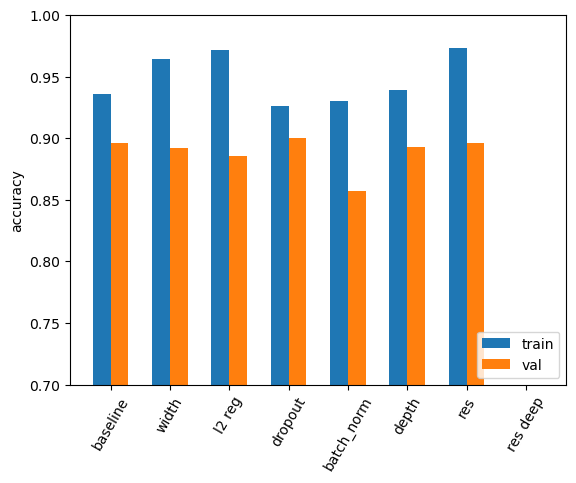

In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()